# Makemore - MLP 2 (initialization and normalization)

This notebook continues the MLP example from the previous notebook, where we implemented the MLP from [(Bengio et al., 2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). We will try to understand the importance of good initialization and normalization. This will help us prepare for training RNNs since they are not easily optimizable.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

seed = 1234
random.seed(seed)

## Prepare the cross-validation datasets

In [2]:
names = open("names.txt").read().split("\n")

print(names[:10])
print(f"Total number of names: {len(names):,}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Total number of names: 32,033


In [3]:
vocab = ["."] + sorted(set([char for name in names for char in name]))
char_to_ix = {char: ix for ix, char in enumerate(vocab)}
ix_to_char = {ix: char for ix, char in enumerate(vocab)}
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [4]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        for char in word + ".":
            X.append(context)
            ix = char_to_ix[char]
            Y.append(ix)
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

In [5]:
random.shuffle(names)

train_names = names[:int(0.8 * len(names))]
val_names = names[int(0.8 * len(names)):int(0.9 * len(names))]
test_names = names[int(0.9 * len(names)):]

X_train, Y_train = build_dataset(train_names)
X_val, Y_val = build_dataset(val_names)
X_test, Y_test = build_dataset(test_names)

print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_val.shape=}, {Y_val.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")

X_train.shape=torch.Size([182542, 3]), Y_train.shape=torch.Size([182542])
X_val.shape=torch.Size([22823, 3]), Y_val.shape=torch.Size([22823])
X_test.shape=torch.Size([22781, 3]), Y_test.shape=torch.Size([22781])


## Define the model

In [6]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 10
hidden_units = 200

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng, requires_grad=True)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng, requires_grad=True)
b1 = torch.randn(hidden_units, generator=rng, requires_grad=True)
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng, requires_grad=True)
b2 = torch.randn(len(vocab), generator=rng, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 11,897


## Optimization

      1 / 200,000: 26.8440
 10,001 / 200,000: 2.4955
 20,001 / 200,000: 4.4785
 30,001 / 200,000: 3.9860
 40,001 / 200,000: 2.9306
 50,001 / 200,000: 2.3205
 60,001 / 200,000: 2.9051
 70,001 / 200,000: 2.4729
 80,001 / 200,000: 2.9030
 90,001 / 200,000: 2.6106
100,001 / 200,000: 2.9980
110,001 / 200,000: 2.0938
120,001 / 200,000: 2.1894
130,001 / 200,000: 2.0791
140,001 / 200,000: 2.2571
150,001 / 200,000: 2.0930
160,001 / 200,000: 2.0707
170,001 / 200,000: 1.7570
180,001 / 200,000: 2.0711
190,001 / 200,000: 2.2088


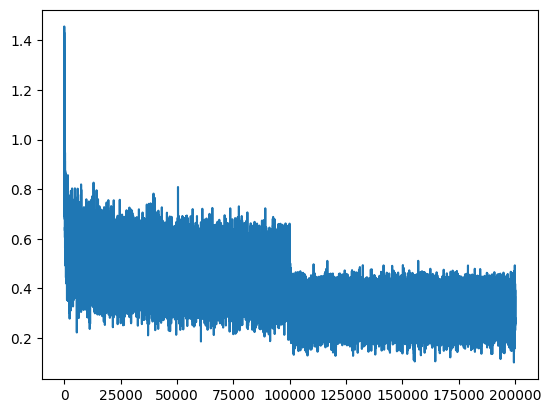

In [7]:
max_steps = 200_000
batch_size = 32

loss_train_i = []
h_pre_active_init = None
h_init = None

for i in range(max_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))
    X, Y = X_train[idx_batch], Y_train[idx_batch]

    # Forward pass
    embed = C[X]  # embed characters into vectors (num_examples, block_size, embed_dim)
    embed_concat = embed.view(len(embed), -1)  # concatenate the vectors (num_examples, block_size * embed_dim)
    h_pre_active = embed_concat @ W1 + b1  # hidden layer pre-activation (num_examples, hidden_units)
    h = torch.tanh(h_pre_active)  # hidden layer activation (num_examples, hidden_units)
    logits = h @ W2 + b2  # output layer (num_examples, len(vocab))
    loss = F.cross_entropy(logits, Y)  # cross-entropy loss

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = 10**-0.5 if i < 100_000 else 10**-1.5  # learning rate decay schedule
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    if i % 10_000 == 0:
        if i == 0:
            h_pre_active_init = h_pre_active.detach().clone()
            h_init = h.detach().clone()
        print(f"{i+1:7,d} / {max_steps:7,d}: {loss.item():.4f}")
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(loss_train_i)

## Evaluation

In [8]:
@torch.no_grad()  # disable gradient tracking; alternative to `with torch.no_grad():`
def cv_split_loss(split_name='train'):
    X, Y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]
    
    embed = C[X]
    embed_concat = embed.view(len(embed), -1)
    h = torch.tanh(embed_concat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    print(f"{split_name.capitalize()} set loss: {loss.item():.4f}")

In [9]:
cv_split_loss('train')
cv_split_loss('val')

Train set loss: 2.0945
Val set loss: 2.1594


## Generate names

In [10]:
rng = torch.Generator().manual_seed(seed)
num_names = 10

for _ in range(num_names):
    name = []
    context = [0] * block_size
    while True:
        # Forward pass
        embed = C[torch.tensor([context])]
        h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        
        # Sample the next character
        next_char_ix = torch.multinomial(probs[-1], num_samples=1, generator=rng).item()
        
        # Update the context
        context = context[1:] + [next_char_ix]
        name.append(ix_to_char[next_char_ix])
        
        if next_char_ix == 0:  # stop when the end-of-name character is sampled
            break
    
    print("".join(name))

kend.
pardani.
fie.
reedar.
ana.
zoyin.
treune.
kovon.
camby.
ana.


## Initialization: 

### Overconfident logits problem
1. You must always have a rough idea of what the initial loss should be. Here, the initial loss (before training) is too high. 
2. The expected initial loss should be around $-\log\Bigg(\frac{1}{\text{len}(\text{vocab})}\Bigg) = -\log\Bigg(\frac{1}{27}\Bigg) = 3.2958$, i.e. the cross-entropy loss of a uniformly assigned output distribution. Such a model confesses to be ignorant about the correct class.
3. The "hockey stick" like shape of the loss curve is a sign of poor initialization. The initial stages of learning is important but is wasted in just learning to squash the logits to a fairly uniform distribution. This is something we already know so, we can initialize more intelligently.
4. You may notice some improvement because the initial stages are now being used for some non-trivial learning.

In [11]:
# Example of poor initialization
rng = torch.Generator().manual_seed(seed)
vocab_size = 4
correct_class_ix = 2

logits = torch.randn(vocab_size, generator=rng) * 10
#logits = torch.zeros(vocab_size)  # good initialization (uniform distribution)
probs = F.softmax(logits, dim=-1)
loss = -probs[correct_class_ix].log()

print(f"Expected loss: {-(1 / torch.tensor(vocab_size)).log().item():.4f}")
print(f"Initial loss: {loss.item():.4f}")

Expected loss: 1.3863
Initial loss: 14.3087


### Neuron saturation problem
1. The hidden layer is using the tanh activation function. The tanh function saturates at $\pm 1$. 
$$
\frac{d\text{tanh}(x)}{dx} = 1 - \text{tanh}^2(x)
$$

2. **Vanishing gradient problem**:
    - If $\text{tanh}(x)=\pm 1$, $1 - \text{tanh}^2(x)=0$. Since the gradient is zero, the neuron kills all gradients from passing through it. Small changes to the activations result in no change in the loss because the activations stay in the saturated region.
    - If $\text{tanh}(x)=0$, $1 - \text{tanh}^2(x)=1$. Since the gradient is one, the neuron does not change the gradient. The gradient from the later layers is just passed through unaltered. This is, in fact, the best case scenario.
    - For all other values of $\text{tanh}(x)$, $1 - \text{tanh}^2(x) \in (0, 1)$. The gradient is scaled down by a factor of $1 - \text{tanh}^2(x)$. So, when the gradient is not killed or passed through unaltered, it is always mitigated. It is never increased.

3. A vast majority of neural activations lie in the saturated region. Small changes to the activations result in no change in the loss because the activations stay in the saturated region.
4. **Squashing activations**: this problem exists with a lot of nonlinearities that squash activations into a flat tail, including— sigmoid, tanh, and ReLU.
5. **Killing neurons**: neurons are killed not only due to poor initialization but also during optimization. If the learning rate is too high, then the activations are pushed into the saturated region. The neuron is killed and cannot be recovered after that because it cannot go through a gradient update.
6. **Non-squashing activations**: Leaky ReLU and to some extent ELU nonlinearities do not suffer from this issue.

Text(0.5, 1.0, 'Hidden layer activation distribution')

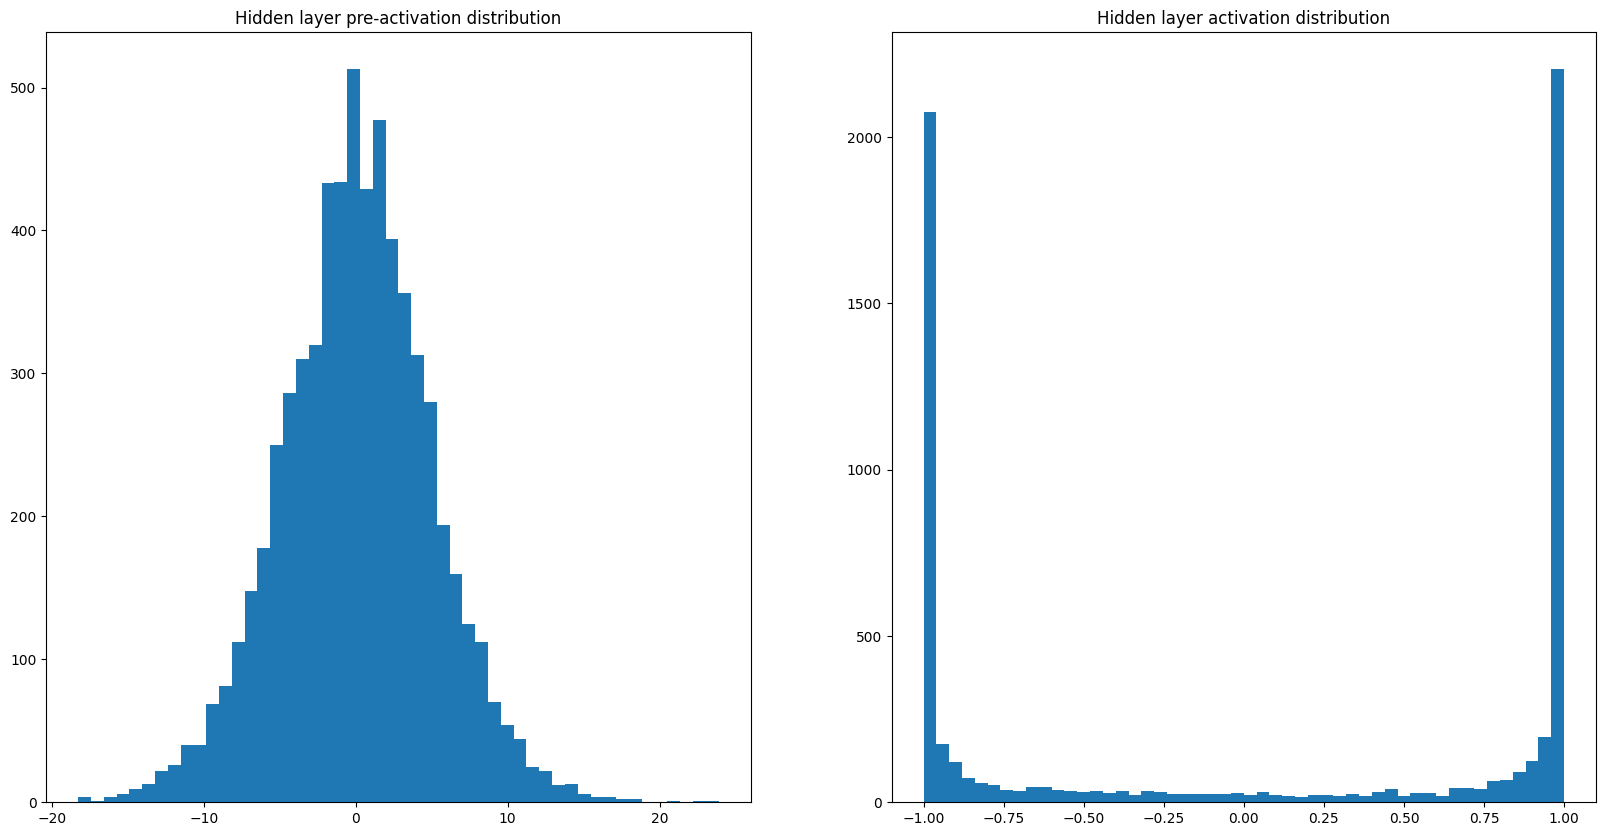

In [12]:
# Visualize saturated tanh activations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(h_pre_active_init.view(-1).tolist(), bins=50)
ax1.set_title("Hidden layer pre-activation distribution")
ax2.hist(h_init.view(-1).tolist(), bins=50)
ax2.set_title("Hidden layer activation distribution")

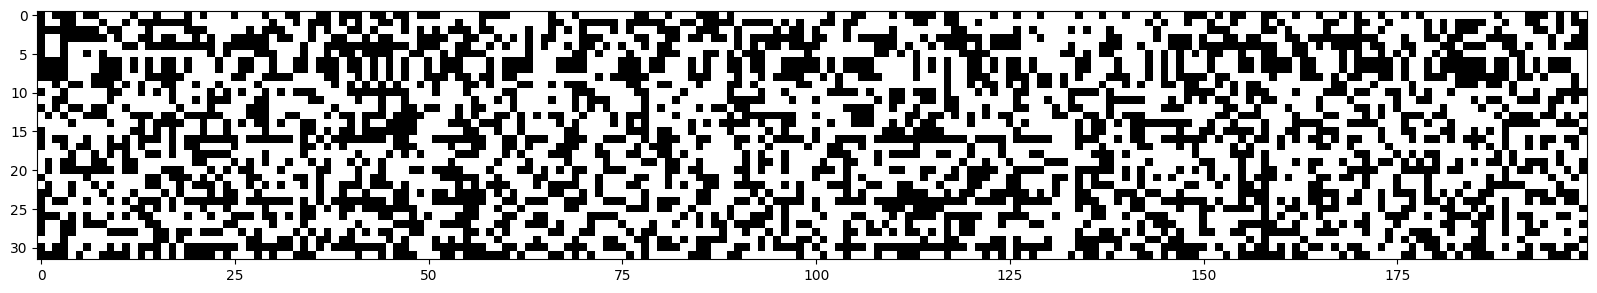

In [13]:
# Visualizing saturated hidden layer activations
plt.figure(figsize=(20,10))
plt.imshow(h_init.abs() > 0.99, cmap='gray', interpolation='nearest')
# columns of completely white pixels are dead neurons i.e. they never learn anything

In [14]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 10
hidden_units = 200

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng) * 0.2  # to prevent saturating tanh neurons 
b1 = torch.randn(hidden_units, generator=rng) * 0.01  # a little bit of entropy from the bias
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng) * 0.01  # non-zero for symmetry breaking
b2 = torch.zeros(len(vocab))  # squash to uniform distribution

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 11,897


      1 / 200,000: 3.2799
 10,001 / 200,000: 2.1162
 20,001 / 200,000: 2.3203
 30,001 / 200,000: 2.6122
 40,001 / 200,000: 1.9153
 50,001 / 200,000: 2.3720
 60,001 / 200,000: 1.9255
 70,001 / 200,000: 2.5817
 80,001 / 200,000: 2.2351
 90,001 / 200,000: 2.3291
100,001 / 200,000: 2.1168
110,001 / 200,000: 2.0948
120,001 / 200,000: 1.6391
130,001 / 200,000: 2.1655
140,001 / 200,000: 2.2890
150,001 / 200,000: 1.9406
160,001 / 200,000: 1.9904
170,001 / 200,000: 2.0031
180,001 / 200,000: 1.7785
190,001 / 200,000: 2.0000


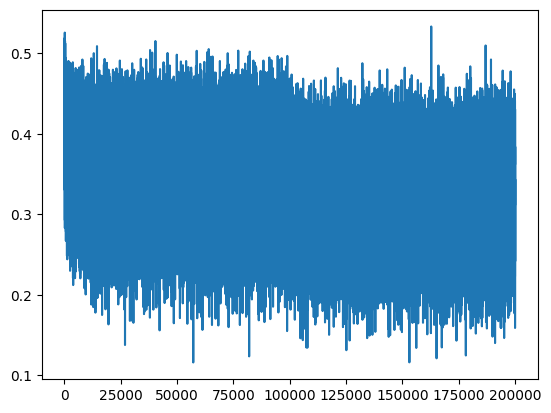

In [15]:
max_steps = 200_000
batch_size = 32

loss_train_i = []
h_pre_active_init = None
h_init = None

for i in range(max_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))
    X, Y = X_train[idx_batch], Y_train[idx_batch]

    # Forward pass
    embed = C[X]  # embed characters into vectors (num_examples, block_size, embed_dim)
    embed_concat = embed.view(len(embed), -1)  # concatenate the vectors (num_examples, block_size * embed_dim)
    h_pre_active = embed_concat @ W1 + b1  # hidden layer pre-activation (num_examples, hidden_units)
    h = torch.tanh(h_pre_active)  # hidden layer activation (num_examples, hidden_units)
    logits = h @ W2 + b2  # output layer (num_examples, len(vocab))
    loss = F.cross_entropy(logits, Y)  # cross-entropy loss

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = 10**-0.5 if i < 100_000 else 10**-1.5  # learning rate decay schedule
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    if i % 10_000 == 0:
        if i == 0:
            h_pre_active_init = h_pre_active.detach().clone()
            h_init = h.detach().clone()
        print(f"{i+1:7,d} / {max_steps:7,d}: {loss.item():.4f}")
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(loss_train_i)

In [16]:
cv_split_loss('train')
cv_split_loss('val')

Train set loss: 2.1106
Val set loss: 2.1473


Text(0.5, 1.0, 'Hidden layer activation distribution')

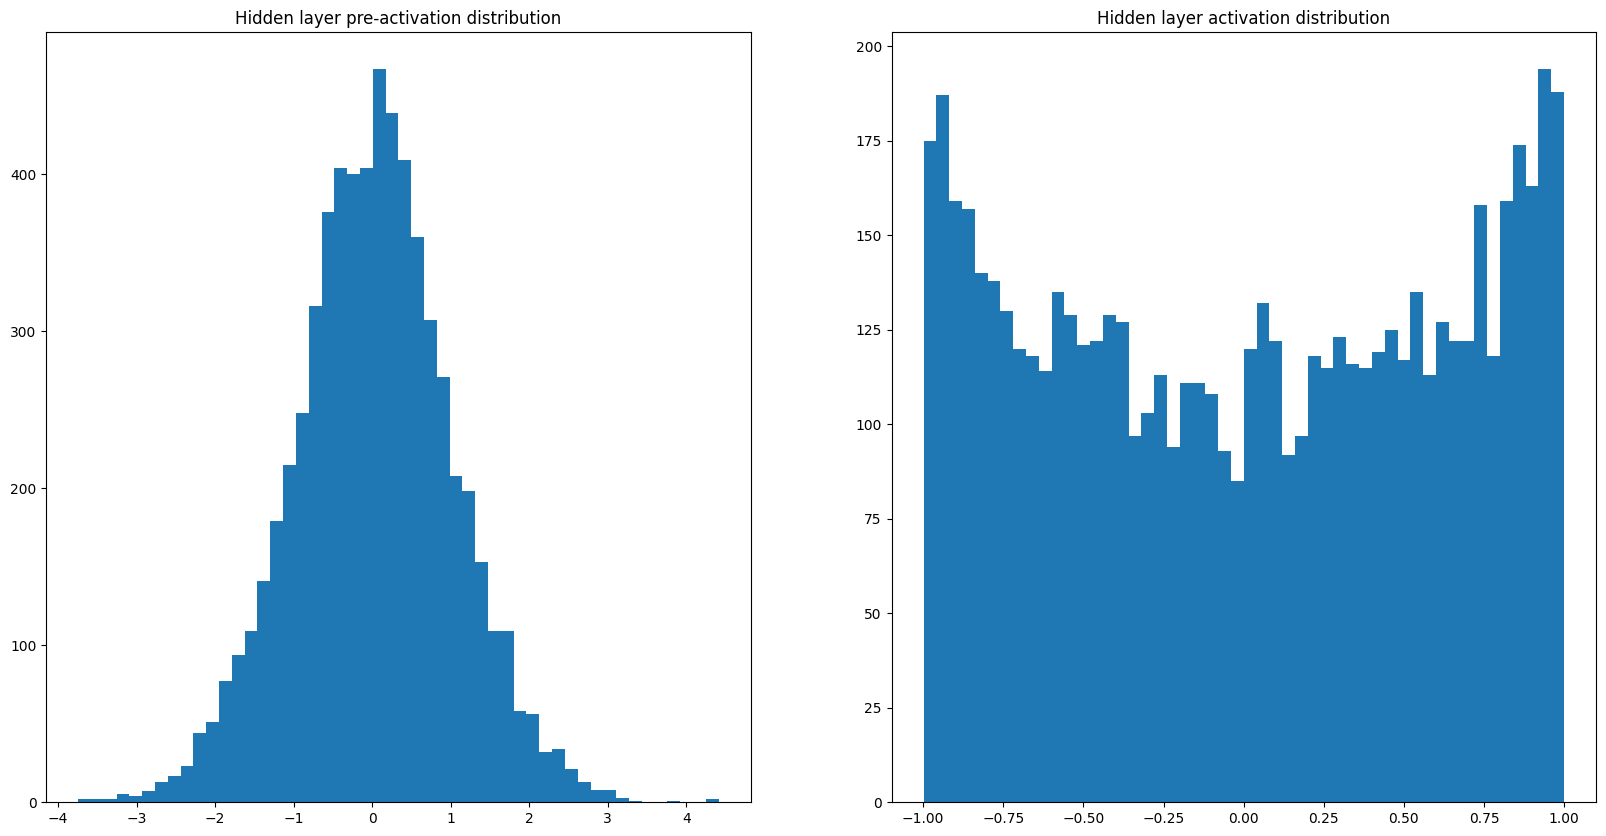

In [17]:
# Visualize less saturated tanh activations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(h_pre_active_init.view(-1).tolist(), bins=50)
ax1.set_title("Hidden layer pre-activation distribution")
ax2.hist(h_init.view(-1).tolist(), bins=50)
ax2.set_title("Hidden layer activation distribution")

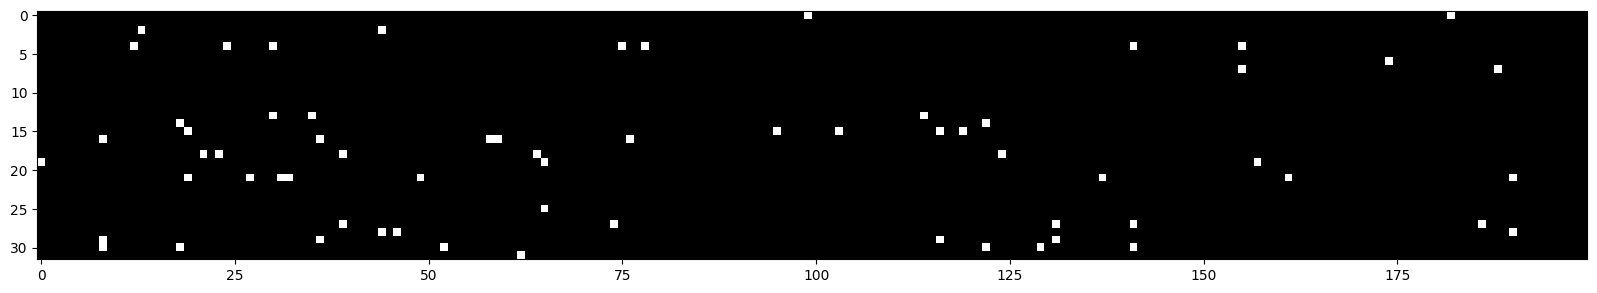

In [18]:
# Very little dead neurons
plt.figure(figsize=(20,10))
plt.imshow(h_init.abs() > 0.99, cmap='gray', interpolation='nearest')

### Kaiming He initialization
1. The initialization problem is a lot more aggravated when training deeper neural networks.
2. We have introduced a lot of magic numbers to prevent saturation and forcing the logits to be uniformly distributed.
3. There are principled approaches to initializing neural networks that do not require any magic numbers.